# Lab 5 Sparse Spam Classification 

This notebook provides an example of an app to classify phone SMS messages as either "spam" or "ham" (=not spam).  Some of this content has been adapted from a tutorial by Radimre Hurek:  https://radimrehurek.com/data_science_python/ and has been updated by Dr. Riley.  

Please follow through this notebook linearly and insert your modifications and additions appropriately throughout.  You will also need to update some of the existing cells to conform to the style expectations of the checklist.  

#### This Dataset is a dataset of over 5000 SMS phone messages and their spam or ham classification.

### Lets start with importing some things...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import nltk
import sys
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


## Part 1: Load data, explore

Let's get the dataset and put it in the data folder.

This file contains **a collection of more than 5 thousand SMS phone messages** (see the `readme` file for more info).  First, load them using Pandas with one column named `label` and one named `message`...

In [2]:
messages = pandas.read_csv('/data/cs2300/L5/SMSSpamCollection.txt', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])



You should take a look at the basic statistics for this dataset using Pandas describe() method

In [3]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

add a Pandas column that describes the length of the messages

In [4]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


This will allow you to run the cell below to make a histogram of the length.  

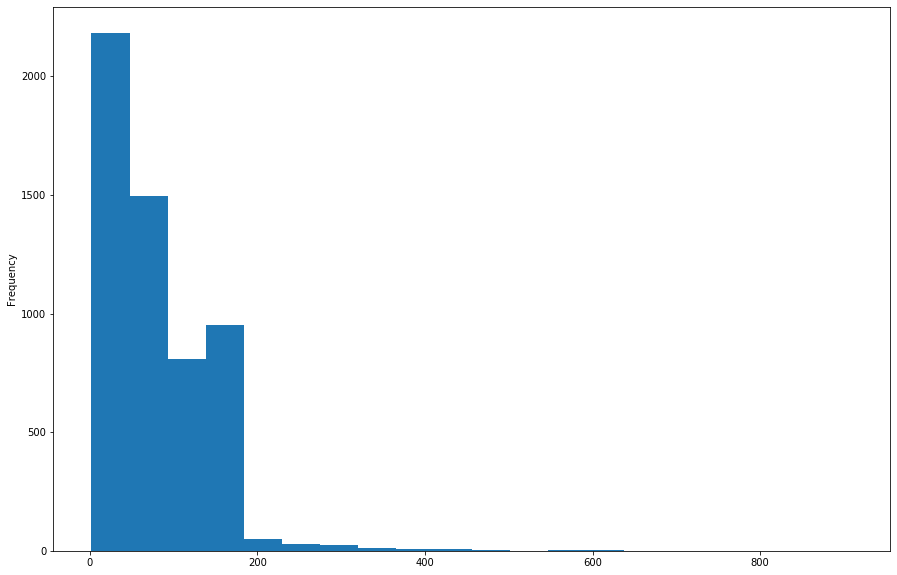

In [5]:
messages['length'].plot(bins=20, kind='hist', figsize=(15, 10))

In [6]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Find and print that really long one...

In [7]:
messages.loc[messages['length'] == 910]


,label,message,length
1085,ham,For me the love should start with attraction.i...,910


We can see if there is there any difference in message length between spam and ham by running the following code to plot them side by side. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f04f9ddc860>,
      dtype=object)

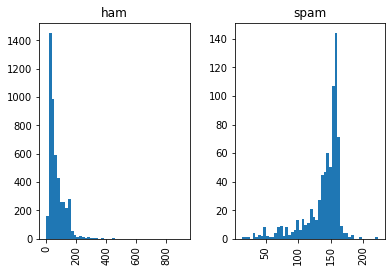

In [8]:
messages.hist(column='length', by='label', bins=50)

Great, but this is not sufficient for us to create a classifier.  We need machine learning!

## Part 2: Data preprocessing

Next we convert the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, here is a function that will split a message into its individual words:

In [9]:
def split_into_tokens(message):
    return TextBlob(message).words

You should tokenize them by applying the split_into_tokens method to the message column of the dataframe in the following cell.  Print the results to convince yourself that they are correct.  You do not need to store these results back in a column of the dataframe (i.e., you do not need to assign it back to a column).  

In [10]:
tokens = messages['message'].apply(split_into_tokens)
tokens.head()

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

With textblob, we can detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

In [11]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

In [12]:
def split_into_lemmas(message):
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

Normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) by applying the split_into_lemmas function below to the message column of the dataframe. The base lemma takes plural nouns and makes them singular - if you want to do more sophisticated lemmatization (e.g., removing verb tenses), call .lemmatize() and pass in the part of speech. Again, you do not need to store these results back in a column of the DataFrame, so you can use `.head()` to view the output.  

In [13]:
tokens = messages['message'].apply(split_into_lemmas)
tokens.head()

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

You can probably think of many more ways to improve the preprocessing: decoding HTML entities (those `&amp;` and `&lt;` we saw above); filtering out stop words (pronouns etc); adding more features, such as an word-in-all-caps indicator and so on.  So keep those in mind for later...

## Part 3: Data to vectors

Now need to convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length


Each vector has as many dimensions as there are unique words in the SMS corpus.  We can count the number of unique words using the following cell...

In [14]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

11012


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. It contains a multitude of various methods and options.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [15]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [16]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)


  (0, 4191)	2
  (0, 4764)	1
  (0, 5365)	1
  (0, 6221)	1
  (0, 6245)	1
  (0, 7139)	1
  (0, 9282)	2
  (0, 9591)	1
  (0, 10056)	1
(1, 11012)


So, nine unique words are in this message.  Two of them appear twice, the rest only once. 

Write some code in the next cell that identifies the words that appear twice.  You are encouraged to use the CountVectorizer's get_feature_names() method to make this easier

In [17]:
feature_name_1 = bow_transformer.get_feature_names()[4191]
feature_name_2 = bow_transformer.get_feature_names()[9282]
print(f'Words that were used twice: {feature_name_1}, {feature_name_2}')

Words that were used twice: U, say


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix (generated using `bow_transformer.transform()` on the appropriate dataframe column).  In the following cell, calculate the sparsity using `.nnz` and the shape.  

In [18]:
messages_bow = bow_transformer.transform(messages['message'])
print(f'Number of Non-Zero Elements: {messages_bow.nnz}')
print(f'Shape of messages_bow: {messages_bow.shape}')
print(f'Sparsity: {(1 - (messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))) * 100} %')

Number of Non-Zero Elements: 81621
Shape of messages_bow: (5574, 11012)
Sparsity: 99.867025384188 %


**In this markdown cell, hypothsize why the sparsity is non-zero:**
Because there are messages that have words in it


Next, lets see what the bow array looks like if we convert it to a "dense" array and print it out.  Lots of 0s right?  

In [19]:
messages_array = messages_bow.toarray()
print(messages_array)
type(messages_array)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


numpy.ndarray

You should next calculate the storage required by both the sparse representation and the full array by using `numpy_array.data.nbytes` to find its size

In [20]:
print(f'Dense Array Storage size: {messages_array.data.nbytes}')
print(f'Bag of Words representation storage size: {messages_bow.data.nbytes}')

Dense Array Storage size: 491047104
Bag of Words representation storage size: 652968


Term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`, and we can apply it to the message we used above.  

In [21]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 10056)	0.22510385070095637
  (0, 9591)	0.1955442748962185
  (0, 9282)	0.49597495370832545
  (0, 7139)	0.4269339327922034
  (0, 6245)	0.3100112284407115
  (0, 6221)	0.2913528957227454
  (0, 5365)	0.2860779240943588
  (0, 4764)	0.25892595706356525
  (0, 4191)	0.391088549792437


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [22]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)
print(messages_tfidf)

(5574, 11012)
  (0, 10754)	0.21213229601299222
  (0, 10579)	0.18167554410946474
  (0, 10384)	0.21213229601299222
  (0, 10061)	0.14837206960284824
  (0, 8703)	0.20860154971594694
  (0, 8407)	0.15067087432963316
  (0, 8163)	0.16242573626983609
  (0, 7587)	0.25289503583337986
  (0, 7478)	0.2993512784929627
  (0, 7268)	0.1008229769857705
  (0, 6902)	0.1757328869964933
  (0, 6874)	0.14339196897060574
  (0, 6235)	0.1811790743555944
  (0, 5825)	0.23930745589325064
  (0, 5324)	0.25736981907741296
  (0, 5323)	0.28576369855283346
  (0, 4792)	0.2993512784929627
  (0, 2158)	0.23182967104573837
  (0, 1562)	0.2993512784929627
  (0, 1176)	0.2761231571631713
  (1, 10675)	0.4010902457332356
  (1, 10321)	0.20081724764839
  (1, 8404)	0.5049322644944293
  (1, 7616)	0.3771878029805894
  (1, 3173)	0.2915507170181676
  :	:
  (5572, 7329)	0.2752494318008217
  (5572, 7268)	0.10973512009181839
  (5572, 7206)	0.11082395540202505
  (5572, 7018)	0.1735585546845164
  (5572, 6945)	0.2011564437133181
  (5572, 6780)	0

## Part 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier:

In [23]:
spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message:

In [24]:
print('predicted:', spam_detector.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


Hooray!

A natural question is to ask, how many messages do we classify correctly overall?  The following cell will calculate this for us...

In [25]:
all_predictions = spam_detector.predict(messages_tfidf)
print('accuracy', accuracy_score(messages['label'], all_predictions))

accuracy 0.9721923214926445


There are quite a few possible metrics for evaluating model performance. Which one is the most suitable depends on the task. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".  Differences between errors can be illuminated using metrics other than accuracy, so in the following cell, and in the cells below, you should use sklearn to calculate recall and precision in addition to accuracy.  Please include statements about what you can interpret from these results

## Part 5: Let's get realistic

In the above "evaluation", we committed a cardinal sin. For simplicity of demonstration, we evaluated accuracy on the same data we used for training. **Never evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.  This is exactly like memorizing the exact answers for an exam without understanding the underlying material!

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

The following code splits the dataset into a training and testing set.  

In [26]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


So, as requested, the test size is 20% of the entire dataset.

Next, lets set up our split datasets to be ready to be used by the Bayes model for training and prediction...

In [27]:
train_messages_bow = bow_transformer.transform(msg_train)
train_tfidf_transformer = TfidfTransformer().fit(train_messages_bow)
train_messages_tfidf = train_tfidf_transformer.transform(train_messages_bow)
test_messages_bow = bow_transformer.transform(msg_test)
test_tfidf_transformer = TfidfTransformer().fit(test_messages_bow)
test_messages_tfidf = test_tfidf_transformer.transform(test_messages_bow)

We can train a new Naive Bayes classifier with only the training data, and test it with the test data, and our accuracy should drop.  In this cell answer: why?  

#### The reason why the accuracy is lower tha what it was previously, is because the training set isn't the test set. Since we split up our data into a test set and a training set, the model cannot simply memorize what it did earlier and predict the exact same outcome again, because it has already seen the data. The way we have it set up now we are seeing its true predictive power and seeing exactly how useful it would be in actually predicting spam or ham.

In [28]:
split_spam_detector = MultinomialNB().fit(train_messages_tfidf, label_train)
test_predictions = split_spam_detector.predict(test_messages_tfidf)
print('updated accuracy', accuracy_score(label_test, test_predictions))

updated accuracy 0.9542600896860987


Next, re-run this experiment changing the test size to a different value (in the subsequent cells of this part) and develop an explanation for the results (it should be different than your accuracy value)

In [29]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.3)
train_messages_bow = bow_transformer.transform(msg_train)
train_tfidf_transformer = TfidfTransformer().fit(train_messages_bow)
train_messages_tfidf = train_tfidf_transformer.transform(train_messages_bow)
test_messages_bow = bow_transformer.transform(msg_test)
test_tfidf_transformer = TfidfTransformer().fit(test_messages_bow)
test_messages_tfidf = test_tfidf_transformer.transform(test_messages_bow)

split_spam_detector = MultinomialNB().fit(train_messages_tfidf, label_train)
test_predictions = split_spam_detector.predict(test_messages_tfidf)
print('updated accuracy', accuracy_score(label_test, test_predictions))

updated accuracy 0.9569635385534967


## Part 6: Next Steps

In the following cells you should make some changes to the dataset (cast to lowercase, remove numbers, remove non-words, add content, lemmatize verbs using .lemmatize("v"), etc) to sufficiently change the sparsity percentage.  The number of columns in your bag of words model should change significantly. **After making your changes to the data set, repeat the size evaluation done in part 3.** The goal of this is see the size comparison in the non-compressed version of the matrix (`toarray`) vs the sparse representation as the size of the data changes.  If we didn't have a sparse representation, our ability to use a BOW model would be very limiting...  Argue how using sparse matrices can enable more powerful data analyses.  

Next, rerun the experiments from part 5 to assess the accuracy of your new dataset and compare it with your previous results.  You should make arguments about what caused the changes and why they make sense. 

## Reloading new spam messages dataframe, because I am paranoid

In [30]:
messages = pandas.read_csv('/data/cs2300/L5/SMSSpamCollection.txt', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])

messages['length'] = messages['message'].apply(len)
pandas.set_option('display.max_rows', None)


### Making tokens that don't have punctuation, upper case letters or numbers

In [31]:
messages['message'] = messages['message'].str.replace(r'[^a-zA-Z0-9 ]', '').str.lower().str.replace('\d+', '')
messages['message'] = messages['message']
messages.head(10)

,label,message,length
0,ham,go until jurong point crazy available only in ...,111
1,ham,ok lar joking wif u oni,29
2,spam,free entry in a wkly comp to win fa cup final...,155
3,ham,u dun say so early hor u c already then say,49
4,ham,nah i dont think he goes to usf he lives aroun...,61
5,spam,freemsg hey there darling its been weeks now ...,147
6,ham,even my brother is not like to speak with me t...,77
7,ham,as per your request melle melle oru minnaminun...,160
8,spam,winner as a valued network customer you have b...,157
9,spam,had your mobile months or more u r entitled t...,154


### BOW model

In [32]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

8077


### The number of unique words has decreased by 3000. It went from 11012 to 8077. A 27 % decrease.

### Calculating BOW model sparsity of new messages

In [33]:
messages_bow = bow_transformer.transform(messages['message'])
print(f'Number of Non-Zero Elements: {messages_bow.nnz}')
print(f'Shape of messages_bow: {messages_bow.shape}')
print(f'Sparsity: {(1 - (messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))) * 100} %')

Number of Non-Zero Elements: 75540
Shape of messages_bow: (5574, 8077)
Sparsity: 99.83221237249174 %


### Changing BOW model to an array

In [34]:
messages_array = messages_bow.toarray()
print(messages_array)
type(messages_array)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


numpy.ndarray

### Calculating size of each representation and comparing

In [35]:
print(f'Dense Array Storage size: {messages_array.data.nbytes}')
print(f'Bag of Words representation storage size: {messages_bow.data.nbytes}')
print(f'Ratio of Dense Array Storage size / Bag of Words Representation: {360169584 / 604320}')

Dense Array Storage size: 360169584
Bag of Words representation storage size: 604320
Ratio of Dense Array Storage size / Bag of Words Representation: 595.9915011914218


#### Size Conclusion: In both versions of messages, the suggested changes and the one with my changes have a big size disparity between the two. The array version is almost 600 times larger than the BOW model. This has a huge impact on performance as well as being able to compute intensive data analysis. Without a BOW model, some large data sets would simply be to large for analysis or would need many computers to run, whereas the BOW model can condense it down and make the information more pallatable for any kind of computer. 

#### Another thing to note, is that if we had a large data set in a dense array format and we didn't have the option of converting to a sparse matrix, many would be tempted to change the data and make edits to it, like removing all the numbers from tokens or other changes like that in efforts to reduce the size. Unfortunately, this could have unwanted side effects, in the case where we may be removing to much.

#### Comparing the previous Array and BOW model to the dense array and BOW model I made, the size decreased by about 27% in the dense array model and about 8% in the BOW model. This makes sense because, the BOW model only stores one of each and not all the occurences of it. 

In [36]:
print(360169584 / 491047104)

#652968
print(604320 /652968 )

0.7334725753723211
0.9254971147131253


In [41]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


In [42]:
train_messages_bow = bow_transformer.transform(msg_train)
train_tfidf_transformer = TfidfTransformer().fit(train_messages_bow)
train_messages_tfidf = train_tfidf_transformer.transform(train_messages_bow)
test_messages_bow = bow_transformer.transform(msg_test)
test_tfidf_transformer = TfidfTransformer().fit(test_messages_bow)
test_messages_tfidf = test_tfidf_transformer.transform(test_messages_bow)

In [43]:
split_spam_detector = MultinomialNB().fit(train_messages_tfidf, label_train)
test_predictions = split_spam_detector.predict(test_messages_tfidf)
print('updated accuracy', accuracy_score(label_test, test_predictions))

updated accuracy 0.957847533632287


## Next, rerun the experiments from part 5 to assess the accuracy of your new dataset and compare it with your previous results. You should make arguments about what caused the changes and why they make sense.

### The accuracy of the model didn't really change much overall. It seems like numbers, punctuation and Upper case letters don't really mean much to spam. Either way the model predicts around 95% to 96% depending on which part of the data set it chooses to train and test on. It is quite interesting that despite the number of unique words decreased by 27% the model was still able to predict at almost the same rate. The model was able to produce similar results despite having less data to work on which is a win in my book.

In [40]:
### End of notebook